In [1]:
import pybinding as pb
import numpy as np
from numpy import sqrt as sqrt
import matplotlib.pyplot as plt
from numpy import exp, dot, einsum, cos, sin, pi
import sympy as sp

In [298]:
delta = 0.7
t = -1

a = 1 #lattice constant
a_0 = a/sqrt(3) # nearest neighbor distance
# onsite energies
Ea = delta
Eb = -delta

# lattice vectors
a1 = np.array([a, 0])
a2 = np.array([-a/2, a*sqrt(3)/2])
graphene_lattice = pb.Lattice(a1=a1, a2=a2)
graphene_lattice.add_sublattices(
    ('A', np.array([0, 0]), Ea), ('B', np.array([0, a_0]), Eb))  # add an atom called 'A' at position [0, 0]

# nearest-neighbor hopping
t = -1

t2 = 0.17*1j
graphene_lattice.add_hoppings(
    ([0, 0], 'A', 'B', t),
    ([-1, -1], 'A', 'B', t),
    ([0, -1], 'A', 'B', t),

    ([1, 0], 'A', 'A', t2),
    ([0, 1], 'A', 'A', t2),
    ([-1, -1], 'A', 'A', t2),

    ([1, 0], 'B', 'B', -t2),
    ([0, 1], 'B', 'B', -t2),
    ([-1, -1], 'B', 'B', -t2),
)
graphene_model = pb.Model(
    graphene_lattice,
    pb.translational_symmetry()
)


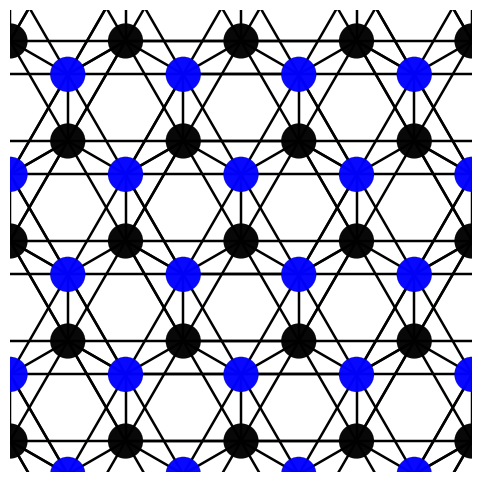

In [319]:
plt.figure(figsize=(6, 6))
graphene_model.plot(num_periods=5,
          hopping = {
  "width": 3, "color": "black", "blend" : 1,
}, sites={"cmap":["black", "blue", "red"], "blend" : 1 })
plt.gca().axis('off');
plt.xlim(-2, 2)
plt.ylim(-2, 2);

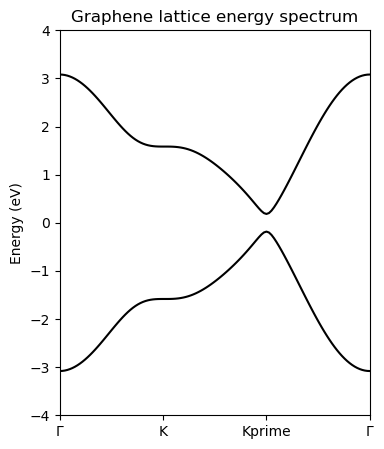

In [299]:
plt.figure(figsize=(4, 5))
solver = pb.solver.lapack(graphene_model)
G1, G2 = graphene_lattice.reciprocal_vectors()

G1 = G1[0:2]
G2 = G2[0:2]
graphene_bzone = graphene_lattice.brillouin_zone()

Gamma = np.array([0, 0])
K = 2/3*G1-1/3*G2
K = graphene_bzone[3]
Kprime = graphene_bzone[4]
M = 1/2*G1+1/2*G2
bands = solver.calc_bands(Gamma, K, Kprime, Gamma)
graphene_energies = bands.energy
k_path = bands.k_path
plt.plot(graphene_energies, color="black")

plt.xticks(k_path.point_indices, [r'$\Gamma$', 'K', 'Kprime', r'$\Gamma$'])
plt.xlim(0, len(k_path)-1)
plt.ylim(-4, 4)
plt.yticks(np.linspace(-4, 4, num=9));
plt.title("Graphene lattice energy spectrum");
plt.ylabel("Energy (eV)");

# Now we calculate the Chern number

In [300]:
solver = pb.solver.lapack(graphene_model)

In [311]:
chern = 0 
N = 400
chern_array = np.zeros((N, N))
N2 = 5000
for k1 in range(0, N):
    for k2 in range(0, N):
        k = G1 * k1/N + G2 * k2/N
        delta_k_1 = G1/N2
        delta_k_2 = G2/N2
        
        solver.set_wave_vector(k)
        h = graphene_model.hamiltonian.toarray()
        psi_0 = solver.eigenvectors[:, 0]
        psi_1 = solver.eigenvectors[:, 1]
        e_0 = solver.eigenvalues[0]
        e_1 = solver.eigenvalues[1]
        
        solver.set_wave_vector(k + delta_k_1)
        h_delta_1 = graphene_model.hamiltonian.toarray()
        
        solver.set_wave_vector(k + delta_k_2)
        h_delta_2 = graphene_model.hamiltonian.toarray()
        
        overlap1 = np.einsum("i, ij, j->", np.conj(psi_1), (h_delta_2-h)*N2, psi_0)/(e_0-e_1)
        overlap2 = np.einsum("i, ij, j->", np.conj(psi_0), (h_delta_1-h)*N2, psi_1)/(e_0-e_1)
        berry_curvature = -np.imag(overlap1 * overlap2)/pi/N**2
        chern += berry_curvature
        chern_array[k1, k2] = berry_curvature

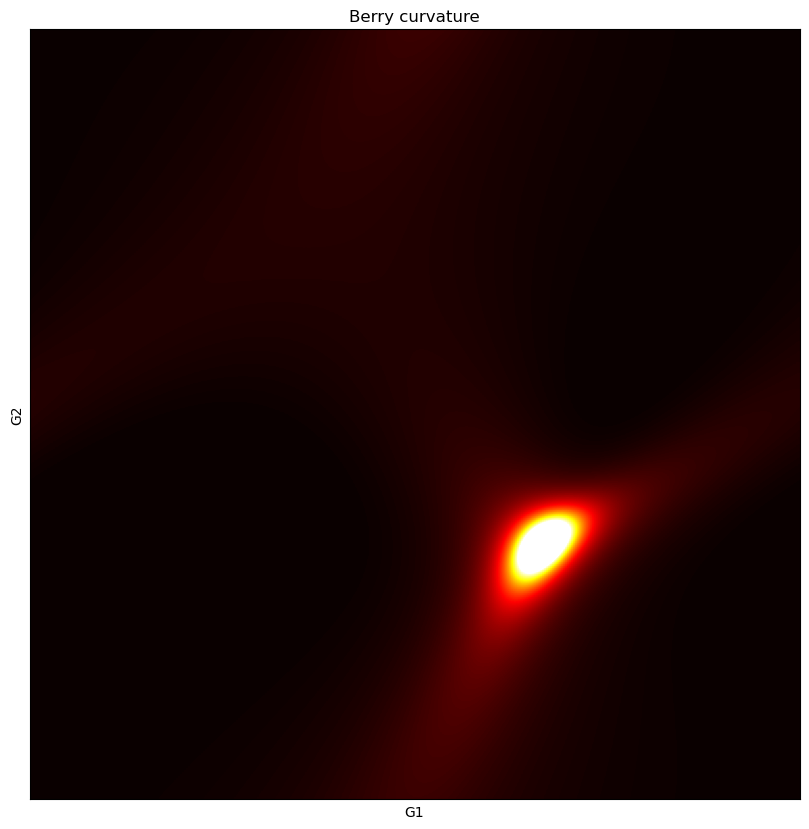

In [324]:
plt.figure(figsize=(10, 10))
plt.imshow(chern_array, vmin=0, vmax=2e-4, cmap="hot")
plt.xticks([])
plt.yticks([]);
plt.xlabel("G1")
plt.ylabel("G2");
plt.title("Berry curvature");

In [320]:
print("Chern number in topological phase: ", np.round(chern, 3))

Chern number in topological phase:  1.0
